In [1]:
# Purpose: Create regression maps for ENSO and SAM climate modes and save them 
#          as a .nc file
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 28. 09. 2021      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/025deg_jra55_iaf/'
save = '/home/561/mv7494/IPOAnt_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
from matplotlib.patches import Rectangle # for shaded rectangle
import pandas as pd
import cartopy.crs as ccrs # for maps     
from matplotlib import gridspec
from cdo import *
cdo = Cdo()
import os
import sys
import scipy
import warnings
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import matplotlib.path as mpath 
import cartopy.feature as cfeature
import matplotlib.patheffects as PathEffects
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import time
import cftime
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature

from dask.distributed import Client
client = Client(n_workers=16)         # careful: do not run with 48 workers here as it will crash
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Creating JRA55-do-1-5-0 sea surface temperature anomalies

In [2]:
%%time
# ------------------------------------------------------------------------------------------------------------ #
# --- which forcing to use, either JRA55-do-1-3, JRA55-do-1-4-0 or JRA55-do-1-5-0                              #
forcing = '1-5-0'                                                                                              #
period = ['1958','2020'] # which period to consider for anomaly calculation                                    #
version = 'v20200916' #'v20190429'                                                                             #
# ------------------------------------------------------------------------------------------------------------ #
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-' + forcing + '/'
out = '/g/data/e14/mv7494/JRA55-do-'+forcing+'/'
var = ['huss','psl','tas','ts', 'uas','vas','prra','prsn','rlds','rsds','friver','tos','taux', 'tauy'] # only eight of the variables I used in my Msc

for i in range(len(var)-2): # loop through all variables
    if var[i] in ['huss','psl','tas','ts','uas','vas']: domain = 'atmos/3hrPt/'; timestep = ['01010000','12312100']; short = 'gr'
    if var[i] in ['prra','prsn','rlds','rsds']:         domain = 'atmos/3hr/';   timestep = ['01010130','12312230']; short = 'gr'
    if var[i] in ['tos']:                               domain = 'ocean/day/';   timestep = ['0101','1231']; short = 'gn'
    if var[i] in ['friver']:                            domain = 'land/day/';   timestep = ['0101','1231']; short = 'gr'
    print(domain+var[i]); print('--- --- --- --- ---')

    # filenames for output files
    f1 = out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[i]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    f2 = out + 'monthly_anom/JRA55-do-'+forcing+'_'+var[i]+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    if os.path.isfile(f1) == True: # skip iteration if final .nc file already exists
        continue               

# Step I: merge files, create monthly mean fields and detrend
    cdo.monmean(input = '-mergetime ' + base + domain + var[i] + '/'+short+'/'+version+'/' + 
                var[i] + '_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-' + forcing + '_'+short+'_{' + period[0] + '..' + period[1] + '}*',
                output = f1, force=False)
# Walltime: 23min 19s for one variable  

# Step II: create monthly anomalies
    field = xr.open_dataset(f1)
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[i]].drop('month').to_netcdf(f2) # save as netcdf file
# Walltime: 52.5 s for one variable

# # Alternative Step II: create monthly mean and remove that to get the anomalies
# #     field = xr.open_dataset(f1)
# #     anom = field.groupby('time.month') - field.groupby('time.month').mean('time')
# #     anom.to_netcdf(f2) # Wall time: 42.5 s for one field
# #     cdo.yseassub(input = f1 +' -yseasavg -selyear,1958/1988 ' + f1, output = f2, force=False)

# Step II: also calculating wind stresses
rho_a = 1.25 # kg m$^{-3}$ reference air density at sea level
C_D = 1.5e-3 # unitless drag coefficient (Kara et al. 2007)
uas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[4]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').uas
vas = xr.open_dataset(out + 'monthly_mean/JRA55-do-'+forcing+'_'+var[5]+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc').vas

print('atmos/3hrPt/taux'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*uas).to_dataset(name='taux').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_taux_monthly_mean_'+period[0]+'-'+period[1]+'.nc')
print('atmos/3hrPt/tauy'); print('--- --- --- --- ---')
(rho_a*C_D*np.sqrt(uas*uas+vas*vas)*vas).to_dataset(name='tauy').to_netcdf(out+'monthly_mean/JRA55-do-'+forcing+'_tauy_monthly_mean_'+period[0]+'-'+period[1]+'.nc')

# also detrend the wind stress fields and create anomalies
for s in range(2):
    if s == 0: letter = 'x'
    if s == 1: letter = 'y'
    tau1 = out+'monthly_mean/JRA55-do-'+forcing+'_tau'+letter+'_monthly_mean_'+period[0]+'-'+period[1]+'.nc'
    tau2 = out+'monthly_anom/JRA55-do-'+forcing+'_tau'+letter+'_monthly_anom_'+period[0]+'-'+period[1]+'.nc'
    cdo.detrend(input=tau1, output = tau1.replace('.nc','_detrend.nc'), force=False)
    field = xr.open_dataset(tau1.replace('.nc','_detrend.nc'))              # selecting taux or tauy variable
    (field.groupby('time.month') - field.groupby('time.month').mean('time'))[var[s+12]].drop('month').to_netcdf(tau2) # save as netcdf file

# Total Walltime for all 11 vars: 4h 3s
# Wall time: 26.8 s

atmos/3hrPt/huss
--- --- --- --- ---
atmos/3hrPt/psl
--- --- --- --- ---
atmos/3hrPt/tas
--- --- --- --- ---
atmos/3hrPt/ts
--- --- --- --- ---
atmos/3hrPt/uas
--- --- --- --- ---
atmos/3hrPt/vas
--- --- --- --- ---
atmos/3hr/prra
--- --- --- --- ---
atmos/3hr/prsn
--- --- --- --- ---
atmos/3hr/rlds
--- --- --- --- ---
atmos/3hr/rsds
--- --- --- --- ---
land/day/friver
--- --- --- --- ---
ocean/day/tos
--- --- --- --- ---
atmos/3hrPt/taux
--- --- --- --- ---
atmos/3hrPt/tauy
--- --- --- --- ---
CPU times: user 13.8 s, sys: 17.1 s, total: 30.9 s
Wall time: 47.4 s


### Calculating the IPO index

In [3]:
%%time
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/'
vars = ['tos', 'psl', 'uas', 'vas']

# SST_mean = xr.open_mfdataset(base + '/ocean/day/tos/gn/v20200916/' + 'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_*.nc').tos.resample(time="1MS").mean(dim="time")
# SST_anom = (SST_mean.groupby("time.month") - (SST_mean[156:505,:,:].groupby("time.month").mean("time")))[0:722,:,:] # for the climatology, select Jan 1971 to Jan 2000. 
#                                                                                                                     # for the full time series, select 1958-2019 (61 years)
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
jra55_ssta = xr.open_dataset(base + 'JRA55-do-1-5-0_tos_monthly_anom_1958-2020.nc').tos

# The index is based on the difference between the SSTA averaged over the central equatorial Pacific 
# and the average of the SSTA in the Northwest and Southwest Pacific. The regions used to calculate 
# the index shown in the map above and are:          Region 1: 25°N–45°N, 140°E–145°W
#                                                    Region 2: 10°S–10°N, 170°E–90°W
#                                                    Region 3: 50°S–15°S, 150°E–160°W 
sel_lat = [ 115,  135,   79,  100,   39,   74]       # [25°N, 45°N, 10°S, 10°N, 50°S, 15°S]
sel_lon = [  140,   215,   170,   270,   150,   200] # [140°E, 215°E, 170°E, 270°E, 150°E, 200°E]
IPO_r1 = jra55_ssta[:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean(['lat', 'lon']) 
IPO_r2 = jra55_ssta[:,sel_lat[2]:sel_lat[3], sel_lon[2]:sel_lon[3]].mean(['lat', 'lon']) 
IPO_r3 = jra55_ssta[:,sel_lat[4]:sel_lat[5], sel_lon[4]:sel_lon[5]].mean(['lat', 'lon']) 

TPI_JRA55_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2) # calculate tripole index

CPU times: user 772 ms, sys: 633 ms, total: 1.4 s
Wall time: 5.6 s


### Tripole index from ERA5 instead

In [4]:
%%time
import glob
base_era = '/g/data/rt52/era5/single-levels/monthly-averaged/sst/'
filenames = glob.glob(base_era + '*/*.nc')  # list of all .nc files available in the subfolders
era5_sst = xr.open_mfdataset(filenames).sst # open all the files
era5_ssta = (era5_sst.groupby("time.month") - (era5_sst[144:493,:,:].groupby("time.month").mean("time"))) # for the climatology, select Jan 1971 to Jan 2000 
era5_ssta.attrs=dict(Note='Anomalies relative to Jan 1971 to Jan 2000 climatology')
if not os.path.exists('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc'):
    print('file not yet saved, doing that now')
    era5_ssta.to_netcdf('/g/data/e14/mv7494/ERA5/monthly_anom/ERA5_sst_monthly_anom_1959-2021.nc')
print('Saving anomalies as .nc file done now')
# Wall time: 1min 38s

Saving anomalies as .nc file done now
CPU times: user 13.7 s, sys: 4.73 s, total: 18.5 s
Wall time: 38.3 s


In [5]:

# Tripole Index Region
# R1: 25°N–45°N, 140°E–145°W
# R2: 10°S–10°N, 170°E–90°W
# R3: 50°S–15°S, 150°E–160°W

sel_lat = [180, 260, 180, 260, 320, 400, 320, 400, 420, 560, 420, 560]
sel_lon = [1280, 1440, 0, 140, 1400, 1440, 0, 360, 1320, 1440, 0, 80]

IPO_r1 = era5_ssta[:,sel_lat[0]:sel_lat[1],sel_lon[0]:sel_lon[1]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[2]:sel_lat[3],sel_lon[2]:sel_lon[3]].mean(['longitude', 'latitude'])
IPO_r2 = era5_ssta[:,sel_lat[4]:sel_lat[5],sel_lon[4]:sel_lon[5]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[6]:sel_lat[7],sel_lon[6]:sel_lon[7]].mean(['longitude', 'latitude'])
IPO_r3 = era5_ssta[:,sel_lat[8]:sel_lat[9],sel_lon[8]:sel_lon[9]].mean(['longitude', 'latitude']) + era5_ssta[:,sel_lat[10]:sel_lat[11],sel_lon[10]:sel_lon[11]].mean(['longitude', 'latitude'])
TPI_ERA5_raw = (IPO_r2 - (IPO_r1 + IPO_r3)/2)[:768] # calculate the tripole index and select 1959-01-01 to 2022-12-01
TPI_ERA5_raw

<xarray.DataArray 'sst' (time: 768)>
dask.array<getitem, shape=(768,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1959-01-01 1959-02-01 ... 2022-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [6]:
TPI_ERA5_raw[0:40].values

array([ 8.2612628e-01,  7.3243135e-01,  4.3931118e-01,  7.7802742e-01,
        8.3368284e-01,  2.1241271e-01, -3.8162130e-01,  1.0025504e-01,
        1.9603431e-02,  4.6687284e-01,  2.3335695e-02, -5.4096627e-01,
       -2.8997377e-02, -4.1648245e-01,  1.8993989e-01,  1.9735244e-01,
        9.6958131e-04, -2.0598745e-01, -9.0857190e-01, -4.7883099e-01,
       -1.1764024e+00,  7.8327075e-02, -1.8594548e-02,  2.6038432e-01,
        8.6689478e-01,  4.0369782e-01,  3.8940758e-03,  1.3595554e-01,
       -4.1347566e-01, -7.4465495e-01, -9.0223920e-01, -9.5207572e-01,
       -1.2941664e+00, -1.3843985e+00, -1.6249299e+00, -1.3084648e+00,
       -1.5848081e+00, -1.1441461e+00, -1.6065419e+00, -1.3373914e+00],
      dtype=float32)

In [7]:
a = np.linspace(0,27,28) # example of time series
def chunker(seq, size): # function that lets me loop through a time series in chunks of x values 
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
for group in chunker(a, 10): # select chunks of 10
   print(repr(group),)

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])
array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])
array([20., 21., 22., 23., 24., 25., 26., 27.])


In [8]:
base2 = '/g/data/e14/mv7494/'
df = pd.read_fwf(base2 + 'tpi.timeseries.ersstv5.data') # read text file into pandas DataFrame
df = df.iloc[104:169,:]
# df.rename(columns={'index': 'Index'}, inplace=True)
df = df.set_axis(['Year', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l'], axis=1) # replace column headers
df

,Year,a,b,c,d,e,f,g,h,i,j,k,l
104,1958,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,1959,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,1960,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,1961,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,1962,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,2018,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,2019,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,2020,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274
167,2021,-1.260,-1.127,-0.989,-0.979,-1.000,-0.865,-0.897,-0.739,-1.051,-1.329,-1.597,-1.757


In [9]:
# rename the column to year
# reset index
# df = df.rename(columns={'index': 'Index'}, inplace=True)
df = df.drop(['Year'], axis=1)
df.index.names = ['Index']
df

,a,b,c,d,e,f,g,h,i,j,k,l
Index,,,,,,,,,,,,
104,1.266,1.041,0.664,0.585,0.694,0.605,0.343,0.329,0.177,0.015,0.199,0.387
105,0.358,0.161,-0.020,0.147,0.063,0.096,-0.242,-0.191,-0.322,0.047,-0.070,-0.191
106,-0.084,-0.155,0.021,0.127,-0.048,-0.121,-0.396,-0.139,-0.397,-0.335,-0.359,-0.066
107,0.182,0.222,-0.030,0.017,-0.324,-0.288,-0.661,-0.695,-0.862,-0.992,-0.517,-0.678
108,-0.680,-0.524,-0.616,-0.685,-1.008,-0.978,-0.874,-0.496,-0.830,-0.886,-0.689,-0.653
...,...,...,...,...,...,...,...,...,...,...,...,...
164,-1.025,-1.027,-1.069,-0.732,-0.638,-0.542,-0.287,-0.225,-0.147,-0.024,0.004,0.119
165,0.016,-0.088,0.017,0.084,0.117,-0.057,-0.173,-0.390,-0.371,-0.198,-0.035,-0.079
166,-0.160,-0.283,-0.331,-0.077,-0.429,-0.726,-0.858,-1.100,-1.360,-1.393,-1.627,-1.274


In [10]:
df2 = df.melt(var_name='Month', value_name="Value", ignore_index = False).sort_values(['Index', 'Month']) # melt df into a long format
# df2.Month = pd.to_numeric(df2.Month, errors='coerce')
# TPI_NOAA_raw = df2['Value'].to_numpy()
a = df2.iloc[:,1].to_numpy()

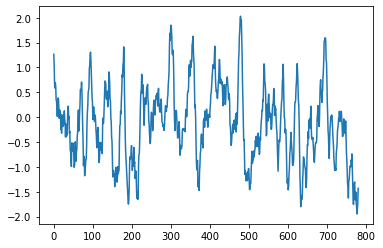

In [11]:
TPI_NOAA_raw = np.zeros(len(a))
for f in range(len(a)):
    TPI_NOAA_raw[f] = a[f]
plt.plot(TPI_NOAA_raw)

CPU times: user 28.8 ms, sys: 0 ns, total: 28.8 ms
Wall time: 22 ms


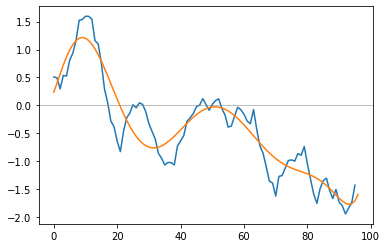

In [12]:
%%time
# fitting a polynomial for the NOAA time series from 2012-2022

length = 96
time = np.linspace(0,length,length)
TPI_NOAA_short = TPI_NOAA_raw[-length:] 
plt.plot(TPI_NOAA_short[-length:]) # 2013-03-15 to 2022-12-15
plt.axhline(0, c='grey', linewidth=.5) # last nine years: 2013 to 2022

z1 = np.polyfit(time, TPI_NOAA_short, 8) # only consider the non-NAN values

# z1 = np.polyfit(time,OHC_ctrl.values, 1) # polyfit for values unequal NaN
p1 = np.poly1d(z1) # construct the polynomial 
plt.plot(time,p1(time))

### Plotting routine IPO tripole index

CPU times: user 21.4 s, sys: 671 ms, total: 22.1 s
Wall time: 22.7 s


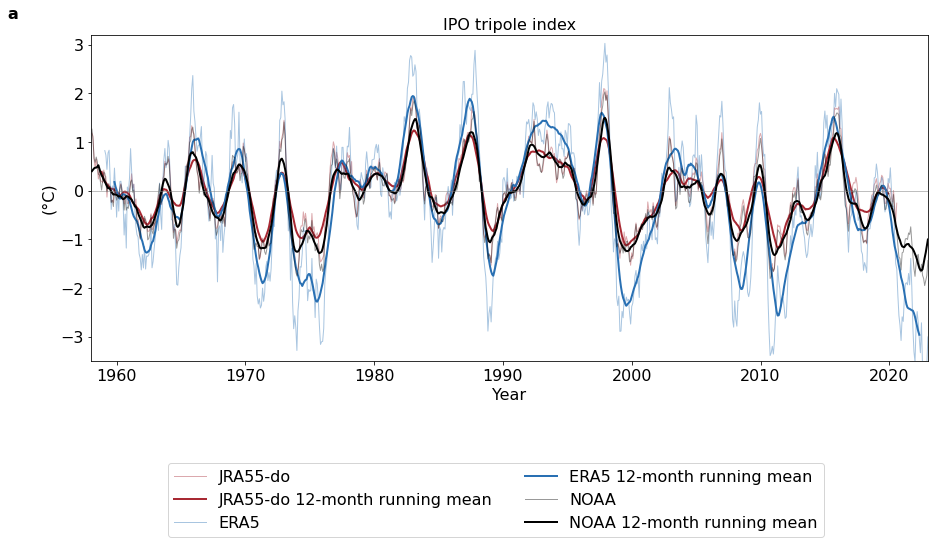

In [100]:
%%time
fig = plt.figure(figsize=(15,6))
time = np.linspace(1958.08,2020.58,751)
ax1 = plt.subplot(1,1,1)
plt.plot(time, TPI_JRA55_raw, label='JRA55-do', c=rotblau[3], alpha=.4, linewidth=1)
plt.plot(time, TPI_JRA55_raw.rolling(time=18, center=True).mean(), label='JRA55-do 12-month running mean', c=rotblau[3], linewidth=2)

# ax1.axvspan(1958, 1979, color=rotblau[12], alpha=.3) # shade period 
# ax1.axvspan(1979, 1998, color=rotblau[8], alpha=.3) 
# ax1.axvspan(1998, 2018, color=rotblau[12], alpha=.3)

# ax1.hlines(np.mean(TPI_JRA55_raw[0:252]).values, xmin=1958, xmax=1979, linewidth=2, color = rotblau[16])
# plt.text(1960, -1.5, str(np.round(np.mean(TPI_JRA55_raw[0:252]).values,2)) +' °C', fontsize=16, c = rotblau[16])

# ax1.hlines(np.mean(TPI_JRA55_raw[253:480]).values, xmin=1979, xmax=1997, linewidth=2, color = rotblau[4])
# plt.text(1980, -1.5, str(np.round(np.mean(TPI_JRA55_raw[253:480]).values,2)) +' °C', fontsize=16, c = rotblau[4])

# ax1.hlines(np.mean(TPI_JRA55_raw[481:]).values, xmin=1997, xmax=2018, linewidth=2, color = rotblau[16])
# plt.text(2001, -1.5, str(np.round(np.mean(TPI_JRA55_raw[481:]).values,2)) +' °C', fontsize=16, c = rotblau[16])

# time series using ERA5 data instead ---------------------------------------------------------------------------------------------------------- #
time2 = np.linspace(1959.08,2023,768)
plt.plot(time2, TPI_ERA5_raw, label='ERA5', c=rotblau[17], alpha=.4, linewidth=1)
plt.plot(time2, TPI_ERA5_raw.rolling(time=18, center=True).mean(), label='ERA5 12-month running mean', c=rotblau[17], linewidth=2)

# time series using NOAA data instead ---------------------------------------------------------------------------------------------------------- #
time3 = np.linspace(1958.08,2023,780)
plt.plot(time3, TPI_NOAA_raw, label='NOAA', c='k', alpha=.4, linewidth=1)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w # mode = 'same' to retain original array length
plt.plot(time3, moving_average(TPI_NOAA_raw, 12), label='NOAA 12-month running mean', c='k', linewidth=2)

plt.title('IPO tripole index', fontsize=16); plt.axhline(0, c='grey', linewidth=.5)
ax1.text(-.1, 1.05, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold panel index letter at the top
plt.xticks(fontsize=16); plt.yticks(fontsize=16) # fontsize of ticks
plt.xlabel('Year', fontsize=16); plt.ylabel('(°C)', fontsize=16) # ticklabels
plt.xlim(1958, 2023) # center on axis with data
plt.ylim(-3.5,3.2)

handles, labels = ax1.get_legend_handles_labels() # adding a legend outside the plot
fig.legend(handles, labels, fontsize=16, ncol=2, bbox_to_anchor=(.5, -.3), loc='lower center')

# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_index_from_JRA55-do_1958-2018', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

### Extending the JRA55-do time series to May 2023

In [140]:
base1 = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/atmos/3hrPt/ts/gr/' # 1-Jan-1958 to 15-Jul-2020
base2 = '/g/data/ik11/inputs/JRA-55/JRA55-do-1-5-0-1/mirror/atmos/3hrPt/ts/gr/'                 # 1-Jan-2020 to 31-Dec-2020
base3 = '/g/data/ik11/inputs/JRA-55/JRA55-do-1-5-0-1/mirror/atmos/3hrPt/ts/gr/'                 # 1-Jan-2021 to 10-May-2023 

filenames1 = glob.glob(base1 + '*/*.nc')
filenames2 = glob.glob(base2 + '*/*.nc')  # list of all .nc files available in the subfolders
filenames1
ds1 = xr.open_mfdataset(filenames1).ts.sel(time=slice('1958-01-01', '2019-12-31'))
ds2 = xr.open_mfdataset(filenames2).ts

In [144]:
ds = xr.concat([ds1,ds2], dim='time')
ds_anom = (ds.groupby("time.month") - (ds1.sel(time=slice('1971-01-01', '2000-01-01')).groupby("time.month").mean("time"))) # for the climatology, select Jan 1971 to Jan 2000
ds_anom

# continue tomorrow with the IPO time series from the extended data up til May 2023

<xarray.DataArray 'ts' (time: 190264, lat: 320, lon: 640)>
dask.array<getitem, shape=(190264, 320, 640), dtype=float32, chunksize=(248, 320, 640), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1958-01-01 ... 2023-02-11T21:00:00
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
    month    (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2 2 2 2 2 2

CPU times: user 38.5 ms, sys: 7.91 ms, total: 46.4 ms
Wall time: 37 ms


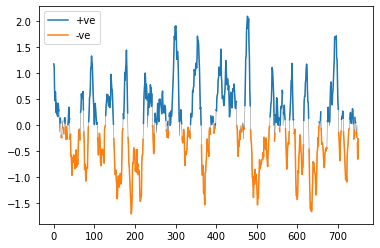

In [25]:
%%time
def fancy_plot(axes_nr):
    axes_nr.coastlines(resolution = '50m') # add coast lines
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    
IPO_positive = TPI_JRA55_raw.where(TPI_JRA55_raw > 0, np.nan) # replace all zeroes by nan
IPO_negative = TPI_JRA55_raw.where(TPI_JRA55_raw < 0, np.nan) 
plt.plot(TPI_JRA55_raw, c='grey', linewidth=.5); plt.plot(IPO_positive, label='+ve'); plt.plot(IPO_negative, label='-ve'); plt.legend()

#### define the input for the figure                              ####
# -- state here which time series to use for the spatial patterns -- #
time_series = TPI_JRA55_raw; suffix = 'full_ts'; filename_extension = ' for the full time series'                  #
# time_series = IPO_positive; suffix = 'positive_ts'; filename_extension = ' when time series is positive'                  #
# time_series = IPO_negative; suffix = 'negative_ts'; filename_extension = ' when time series is negative'                  #
# ------------------------------------------------------------------ # 

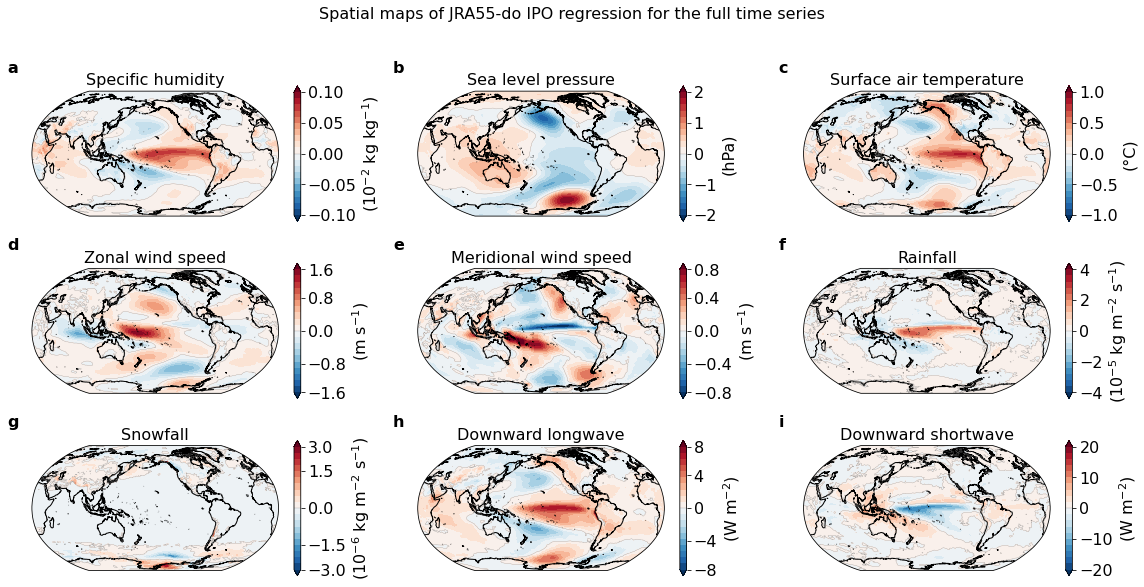

In [15]:
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

# (16,9)
fig = plt.figure(figsize=(16,9),tight_layout=True,facecolor='w',edgecolor='k') 

for v in range(9): # loop through all variables
    # load in the data
    if v <= 8: 
        field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[v] +'_monthly_anom_1958-2020.nc')[var[v]]

        ### Regressing the time series onto the spatial SLP anomalies

        field['time'] = time_series.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align
        field = ((field * time_series) / np.std(time_series)).mean(['time']) # do regression

    if v == 0: scale = 1e2;  ticks = np.linspace(-.1,.1,21)   # huss
    if v == 1: scale = 1e-2; ticks = np.linspace(-2,2,21)   # psl -> convert to hPa
    if v == 2: scale = 1;    ticks = np.linspace(-1,1,21)     # tas
    if v == 3: scale = 1;    ticks = np.linspace(-1.5,1.5,21)     # uas
    if v == 4: scale = 1;    ticks = np.linspace(-.75,.75,21) # vas
    if v == 5: scale = 1e5;  ticks = np.linspace(-4,4,21)     # prrn 
    if v == 6: scale = 1e6;  ticks = np.linspace(-2.5,2.5,21)     # prsn
    if v == 7: scale = 1;    ticks = np.linspace(-7.5,7.5,21)   # rlds
    if v == 8: scale = 1;    ticks = np.linspace(-20,20,21)   # rsds
    # if v == 9: scale = 1e-4; ticks = np.linspace(-5,5,21)   # friver   

    ax1 = plt.subplot(3,3,v+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    # ------------------------------------ #
    p1  = (field*scale).plot.contourf(ax=ax1, levels = ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (field*scale).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
    cb.set_label(label='('+var_units[v]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(var_titles[v], fontsize=16)
    fancy_plot(ax1)
    ax1.text(-.1, 1.15,string.ascii_lowercase[v], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    
    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.suptitle('Spatial maps of JRA55-do IPO regression' + filename_extension, fontsize=16)
    
    if v < 6: ax1.set_xticklabels([])  # remove unnecessary tick labels
    if v in [1,2,4,5,7,8]: ax1.set_yticklabels([])
    
    # --- saving as 300 dpi .PNG image in specified folder --------------------- #
    plt.savefig(save + 'IPO_regression_fields_Robinson_JRA55-do-1-5-0_' + suffix, 
                dpi=300, facecolor='w',                                          #
                edgecolor='w', orientation='landscape',                          #
                format=None, transparent=False, bbox_inches='tight',             #
                pad_inches=0.1, metadata=None)                                   #
    # --- end of script -------------------------------------------------------- # 
# Wall time: 2min 2s

### EOF analysis of IPO SST regions

CPU times: user 86.4 ms, sys: 13.2 ms, total: 99.5 ms
Wall time: 87.9 ms


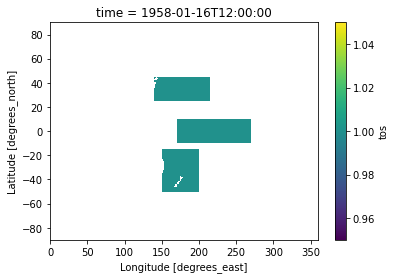

In [16]:
%%time
base = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-5-0/'
vars = ['tos', 'psl', 'uas', 'vas']

# SST_mean = xr.open_mfdataset(base + '/ocean/day/tos/gn/v20200916/' + 'tos_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-5-0_gn_*.nc').tos.resample(time="1MS").mean(dim="time")
# SST_anom = (SST_mean.groupby("time.month") - (SST_mean[156:505,:,:].groupby("time.month").mean("time")))[0:722,:,:] # for the climatology, select Jan 1971 to Jan 2000. 
#                                                                                                                     # for the full time series, select 1958-2019 (61 years)
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
jra55_ssta = xr.open_dataset(base + 'JRA55-do-1-5-0_tos_monthly_anom_1958-2020.nc').tos

# The index is based on the difference between the SSTA averaged over the central equatorial Pacific 
# and the average of the SSTA in the Northwest and Southwest Pacific. The regions used to calculate 
# the index shown in the map above and are:          Region 1: 25°N–45°N, 140°E–145°W
#                                                    Region 2: 10°S–10°N, 170°E–90°W
#                                                    Region 3: 50°S–15°S, 150°E–160°W 
sel_lat = [ 115,  135,   79,  100,   39,   74]       # [25°N, 45°N, 10°S, 10°N, 50°S, 15°S]
sel_lon = [  140,   215,   170,   270,   150,   200] # [140°E, 215°E, 170°E, 270°E, 150°E, 200°E]
IPO_r1 = jra55_ssta[:,sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
IPO_r2 = jra55_ssta[:,sel_lat[2]:sel_lat[3], sel_lon[2]:sel_lon[3]]
IPO_r3 = jra55_ssta[:,sel_lat[4]:sel_lat[5], sel_lon[4]:sel_lon[5]] 

ds = jra55_ssta[0,:,:] # copy structure of data for IPO mask
# select the three IPO regions and mask out data outside the region with zero
ds1 = (ds.where(ds.lat> 25).where(ds.lat< 45).where(ds.lon>140).where(ds.lon<215)).notnull().astype('int')
ds2 = (ds.where(ds.lat>-10).where(ds.lat< 10).where(ds.lon>170).where(ds.lon<270)).notnull().astype('int')
ds3 = (ds.where(ds.lat>-50).where(ds.lat<-15).where(ds.lon>150).where(ds.lon<200)).notnull().astype('int')
IPO_mask = (ds1 + ds2 + ds3) # combine the three region to one mask
IPO_mask = IPO_mask.where(IPO_mask != 0) # replace all zero with nan
IPO_mask.plot()

In [17]:
%%time
modes = 3 # calculate the first 10 EOF modes
data = (jra55_ssta*IPO_mask)

from eofs.xarray import Eof
solver = Eof(data) # EOF region: 10°S-10°N and 100°E-60°W, drop the 'month' attribute so it works
pcs = solver.pcs(npcs=modes, pcscaling=1)
eofs = solver.eofs(neofs=modes, eofscaling=1)
variance = solver.varianceFraction(modes) # the first ten EOF modes account for 78.51% of the variance within the data set

CPU times: user 6.28 s, sys: 2.61 s, total: 8.9 s
Wall time: 15.9 s


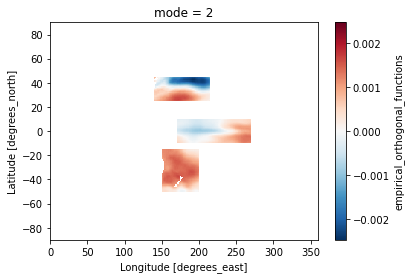

In [29]:
eofs[f,:,:].plot()

### Plotting the first three EOF modes of the JRA55-do-1-5-0 IPO TPI over 1958-01 to 2020-07

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 4.45 s, sys: 601 ms, total: 5.05 s
Wall time: 4.23 s


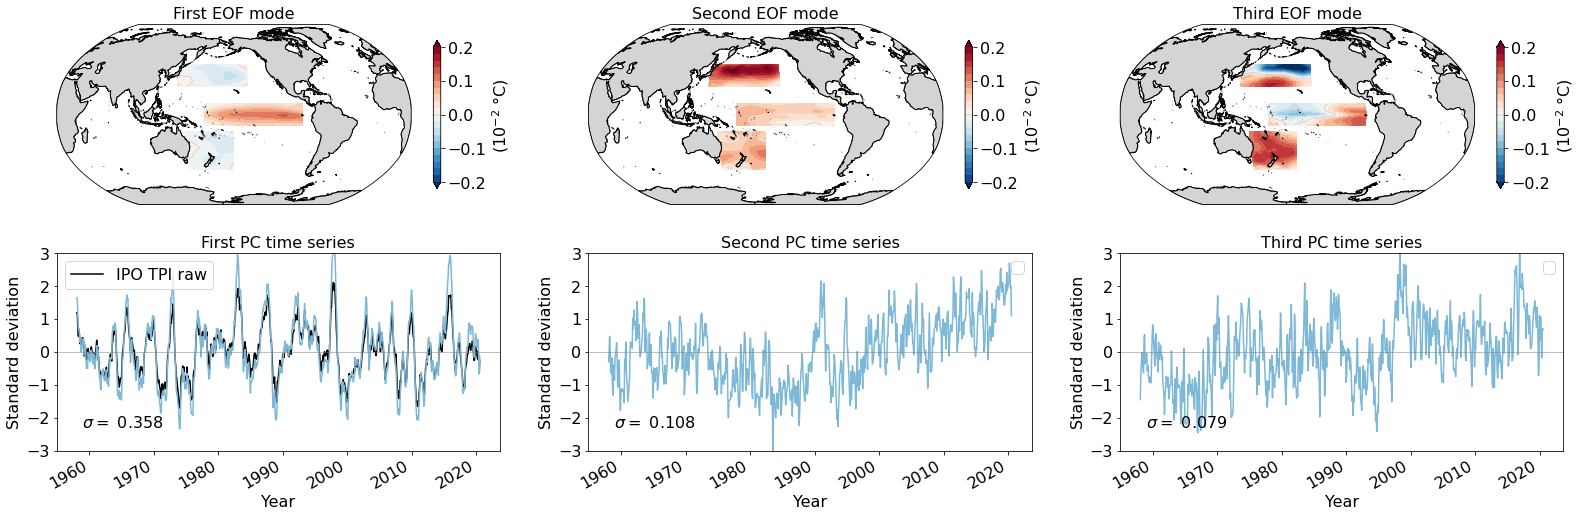

In [72]:
%%time
titles = ['First', 'Second', 'Third']
plt.figure(figsize=(27,8))
for f in range(modes):
    if f == 0: titles
    # ---- ---- ---- first the spatial patterns
    ax1 = plt.subplot(2,modes,f+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    if f == 0:
        p1  = (-eofs[f,:,:]*1e2).plot.contourf(ax=ax1, levels = np.linspace(-.2,.2,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (-eofs[f,:,:]*1e2).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    else:
        p1  = (eofs[f,:,:]*1e2).plot.contourf(ax=ax1, levels = np.linspace(-.2,.2,21), cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
        p11 = (eofs[f,:,:]*1e2).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(10$^{-2}$ °C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(titles[f] + ' EOF mode', fontsize=16)
    fancy_plot(ax1); ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
   
    # ---- ---- ---- now the time series
    plt.subplot(2,modes,f+3+1); 
    if f == 0: 
        TPI_JRA55_raw.plot(label='IPO TPI raw', c = 'k')
        (-1*pcs[:,f]).plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    else:
        pcs[:,f].plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    plt.text(TPI_JRA55_raw.time[10],-2.3, r'$\sigma = $ ' + str(np.round(variance[f].values, 3)), fontsize=16);    plt.ylabel('Standard deviation', fontsize=16) 
    plt.legend(fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(titles[f] + ' PC time series', fontsize=16); plt.xlabel('Year', fontsize=16)
    
# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_TPI_EOF_analysis_first_three_modes', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

### Globally reconstructed figure 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


CPU times: user 12.8 s, sys: 3.03 s, total: 15.8 s
Wall time: 13.2 s


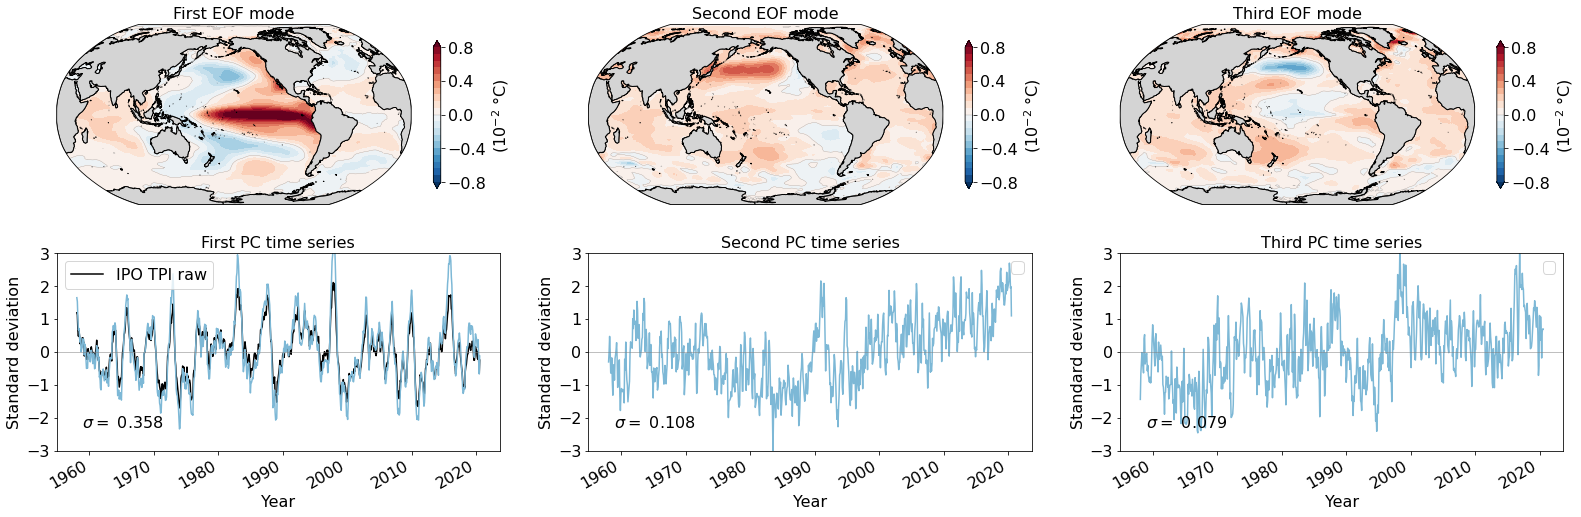

In [98]:
%%time
titles = ['First', 'Second', 'Third']
ticks = np.linspace(-.8,.8,21)
plt.figure(figsize=(27,8))
for f in range(modes):
    # ---- ---- ---- first the spatial patterns
    ax1 = plt.subplot(2,modes,f+1, projection=ccrs.Robinson(central_longitude=200)) # longitude starting at Cape Agulhas (20°E)
    if f == 0: full_spatial = ((-pcs[:,f] * jra55_ssta) / np.std(-pcs[:,f])).mean('time')
    else: full_spatial = ((pcs[:,f] * jra55_ssta) / np.std(-pcs[:,f])).mean('time')
    p1  = (full_spatial).plot.contourf(ax=ax1, levels=ticks, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (full_spatial).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # ------------------------------------ #

    
    

    # add colour bar   
    cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
    cb.set_label(label='(10$^{-2}$ °C)', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    plt.title(titles[f] + ' EOF mode', fontsize=16)
    fancy_plot(ax1); ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
   
    # ---- ---- ---- now the time series
    plt.subplot(2,modes,f+3+1); 
    if f == 0: 
        TPI_JRA55_raw.plot(label='IPO TPI raw', c = 'k')
        (-1*pcs[:,f]).plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    else:
        pcs[:,f].plot(c=rotblau[14], label=None); plt.axhline(0, c='grey', linewidth=.5); plt.ylim([-3,3])
    plt.text(TPI_JRA55_raw.time[10],-2.3, r'$\sigma = $ ' + str(np.round(variance[f].values, 3)), fontsize=16);    plt.ylabel('Standard deviation', fontsize=16) 
    plt.legend(fontsize=16); plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title(titles[f] + ' PC time series', fontsize=16); plt.xlabel('Year', fontsize=16)
    
# --- saving as 300 dpi .PNG image in specified folder --------------------- #
plt.savefig(save + 'IPO_TPI_EOF_analysis_first_three_modes_reconstructed', 
            dpi=300, facecolor='w',                                          #
            edgecolor='w', orientation='landscape',                          #
            format=None, transparent=False, bbox_inches='tight',             #
            pad_inches=0.1, metadata=None)                                   #
# --- end of script -------------------------------------------------------- # 
# Wall time: 21.1 s

### Video how IPO-associated SLP and surface wind anomalies change over the 2014-2022 period
- using a SouthPolarStereo projection

In [19]:
%%time
def fancy_plot2(ax):
    ax.gridlines(color='grey', linewidth=1, alpha=1, # dots as grid lines
                  xlocs=range(-180, 180, 60), # longitude grid lines
                  ylocs= np.linspace(-45, -90, num=4)) # latitude grid lines
    ax.coastlines(); # add coast lines
    theta = np.linspace(0, 2*np.pi, 100); center, radius = [0.5, 0.5], .5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    # colour in land and coastlines
    ax.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 2)
    
base = '/g/data/e14/mv7494/JRA55-do-1-5-0/monthly_anom/'
vars = ['huss_10m', 'psl', 'tas_10m', 'uas_10m', 'vas_10m', 'prrn', 'prsn', 'rlds', 'rsds', 'friver']
var  = ['huss', 'psl', 'tas', 'uas', 'vas', 'prra', 'prsn', 'rlds', 'rsds']
var_titles = ['Specific humidity', 'Sea level pressure', 'Surface air temperature', 'Zonal wind speed', 'Meridional wind speed',
             'Rainfall', 'Snowfall', 'Downward longwave', 'Downward shortwave', 'River runoff']
var_units = ['10$^{-2}$ kg kg$^{-1}$', 'hPa', '°C', 'm s$^{-1}$', 'm s$^{-1}$',
             '10$^{-5}$ kg m$^{-2}$ s$^{-1}$', '10$^{-6}$ kg m$^{-2}$ s$^{-1}$', 'W m$^{-2}$', 'W m$^{-2}$', 'kg m$^{-2}$ s$^{-1}$']

for f in [1,3,4]: # create the spatial IPO regression pattern
    # reconstruct the spatial anomalies with the first ten PC time series regressed onto the spatial anomalies
    field = xr.open_dataset(base + 'JRA55-do-1-5-0_' + var[f] +'_monthly_anom_1958-2020.nc')[var[f]]
    field['time'] = pcs.time # copy over the time dimension so that the hours align (some data sets have data at 10:30, 22.30, 10:00, 20:00, etc.)

    # the first PC is the IPO signal and the second one the anthropogenic impact?
    field_reconstructed = ((field * pcs[:,0])/(np.std(pcs[:,0]))) #+ ((field * pcs[:,1])/(np.std(pcs[:,1]))) + ((field * pcs[:,2])/(np.std(pcs[:,2])))
    
#     ### Regressing the time series onto the spatial anomalies to get the pattern
#     field['time'] = time_series.time # copy over time structure, i.e., shift time axis by 1:30 hrs in SLP_anom so they align
#     spatial_pattern = ((field * time_series) / np.std(time_series)).mean(['time']) # do regression
    
    if f == 1:     psl_sp = field_reconstructed
    if f == 3: uas_10m_sp = field_reconstructed
    if f == 4: vas_10m_sp = field_reconstructed

CPU times: user 1.68 s, sys: 2.95 s, total: 4.63 s
Wall time: 3.98 s


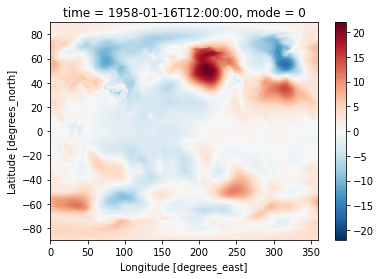

In [20]:
(psl_sp[0,:,:]/1e2).plot()

In [21]:
%%time
# pre-loop preparation
# -------------------------------------------------------------------------------- #
number_of_frames = len(TPI_JRA55_raw)   #
time_series_short = time_series[-number_of_frames:]
# -------------------------------------------------------------------------------- #

for s in range(number_of_frames): # create five (5) movie frames -> the last 5 plots of the time series
    title_suffix = np.datetime_as_string(time_series_short.time[s].values)[:7]
    
    filename = '/g/data/e14/mv7494/' + 'movie_frames/IPO_SLP_wind_anomalies_for_movie_'+str('%03d' % (s,))+'.png'
    if os.path.isfile(filename) == True: # skip iteration if final .nc file already exists
        continue 
    print(title_suffix)
        
    for f in [1,3,4]:
        if f == 1: psl     = psl_sp[s,:,:]; scale_psl = 1e-2; ticks_psl = np.linspace(-15,15,21)   # psl -> convert to hPa
        if f == 3: uas_10m = uas_10m_sp[s,:,:]; scale = 1; ticks = np.linspace(-1,1,21)   # uas
        if f == 4: vas_10m = vas_10m_sp[s,:,:]; scale = 1; ticks = np.linspace(-1,1,21)   # vas
    # plt.figure(figsize=(27,3)); plt.subplot(1,3,1); psl.plot(); plt.subplot(1,3,2); uas_10m.plot(); plt.subplot(1,3,3); vas_10m.plot()
        

    xlab =    [  1.01,    1.04,     .5,   -.055,  -.015,    .58,    .58] # x-position of labels
    ylab =    [   .76,     .22,  -.057,     .22,    .76,    .63,    .80] # y-position of labels
    txt_lab = ['60°E', '120°E', '180°', '120°W', '60°W', '75°S', '60°S'] # label text

    # loop through the 7 labels and surround with white space for higher visibility
    for l in range(len(txt_lab)):
        ax1.text(xlab[l], ylab[l], txt_lab[l], horizontalalignment='center', transform=ax1.transAxes, 
                fontsize=16).set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')]) 



    fig = plt.figure(figsize=(12,6),tight_layout=True,facecolor='w',edgecolor='k'); gs = gridspec.GridSpec(1,1) 
    ax1 = plt.subplot(gs[0,0], projection=ccrs.SouthPolarStereo(central_longitude=0))
    ax1.set_extent([-180, 180, -90, -45], crs=ccrs.PlateCarree())
    # p1 = (field*scale).plot.contourf(transform=ccrs.PlateCarree(), cmap='RdBu_r', levels=ticks,add_colorbar=False)
    # # ------------------------------------------------------------------------------------------------------------------------------------------------ #
    p1  = (psl*scale_psl).plot.contourf(levels = ticks_psl, cmp='RdBu_r',add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p11 = (psl*scale_psl).plot.contour(levels = [0], linewidths=.25, cmap='grey', transform=ccrs.PlateCarree())
    # # ------------------------------------------------------------------------------------------------------------------------------------------------ #
    
    # add colour bar   
    cb = plt.colorbar(p1, shrink=.55, orientation='vertical') 
    cb.set_label(label='('+var_units[1]+')', size=16)
    cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    cb.locator = tick_locator;cb.update_ticks() 
    cb.add_lines(p11) # add contours to colour bar

    # adding 10 m wind data
    # specifics for the wind speed arrows
    X = uas_10m.lon; Y = uas_10m.lat
    U = uas_10m; V = vas_10m
    # widths = np.linspace(-.0001, .0001, X.size)
    # Add the wind stress arrows, only plotting every 30th data point.
    Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), 
               to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
               scale=70, minshaft = 2, scale_units='height', transform=ccrs.PlateCarree(), width=.005, linewidths=.3, edgecolor=('w')) 
                          # minshaft = select minimum sized arrow (i.e., only those larger than 2)
    # reference key on the map
                        # x0,   y0, scale
    qk = plt.quiverkey(Q, .75, 0, 3, r'3 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 
    fancy_plot2(ax1)    

    # fig.patch.set_linewidth(2); fig.patch.set_edgecolor('cornflowerblue') # border around the full plot to see the empty white space I have
    plt.title('IPO SLP and wind anomalies, ' + title_suffix, fontsize=16)
            
    # --- saving as 300 dpi .PNG image in specified folder ---------------------------------------- #
    plt.savefig(filename,  # # add leading zeroes to file name
                dpi=300, facecolor='w',                                                             #
                edgecolor='w', orientation='landscape',                                             #
                format=None, transparent=False, bbox_inches='tight',                                #
                pad_inches=0.1, metadata=None)                                                      #
    # --- end of script --------------------------------------------------------------------------- # 
    if s > 0: plt.close() # don't show plot in notebook cell
# Wall time: 2min 2s

1997-03
1998-03
1998-04
1998-05
1998-06
1998-07
1998-08
1998-09
1998-10
1998-11
1998-12
1999-01
1999-02
1999-03
1999-04
1999-05
1999-06
1999-07
1999-08
1999-09
1999-10
1999-11
1999-12
2000-01
2000-02
2000-03
2000-04
2000-05
2000-06
2000-07
2000-08
2000-09
2000-10
2000-11
2000-12
2001-01
2001-02
2001-03
2001-04
2001-05
2001-06
2001-07
2001-08
2001-09
2001-10
2001-11
2001-12
2002-01
2002-02
2002-03
2002-04
2002-05
2002-06
2002-07
2002-08
2002-09
2002-10
2002-11
2002-12
2003-01
2003-02
2003-03
2003-04
2003-05
2003-06
2003-07
2003-08
2003-09
2003-10
2003-11
2003-12
2004-01
2004-02
2004-03
2004-04
2004-05
2004-06
2004-07
2004-08
2004-09
2004-10
2004-11
2004-12
2005-01
2005-02
2005-03
2005-04
2005-05
2005-06
2005-07
2005-08
2005-09
2005-10
2005-11
2005-12
2006-01
2006-02
2006-03
2006-04
2006-05
2006-06
2006-07
2006-08
2006-09
2006-10
2006-11
2006-12
2007-01
2007-02
2007-03
2007-04
2007-05
2007-06
2007-07
2007-08
2007-09
2007-10
2007-11
2007-12
2008-01
2008-02
2008-03
2008-04
2008-05
2008-06


In [51]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #